In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import network_dynamics as ndyn

# Simulation #1 - Fully connected, Gaussian Kernel

We're looking to see that global inhibition is working, that eventually firing rates plateau when there is no longer external input.

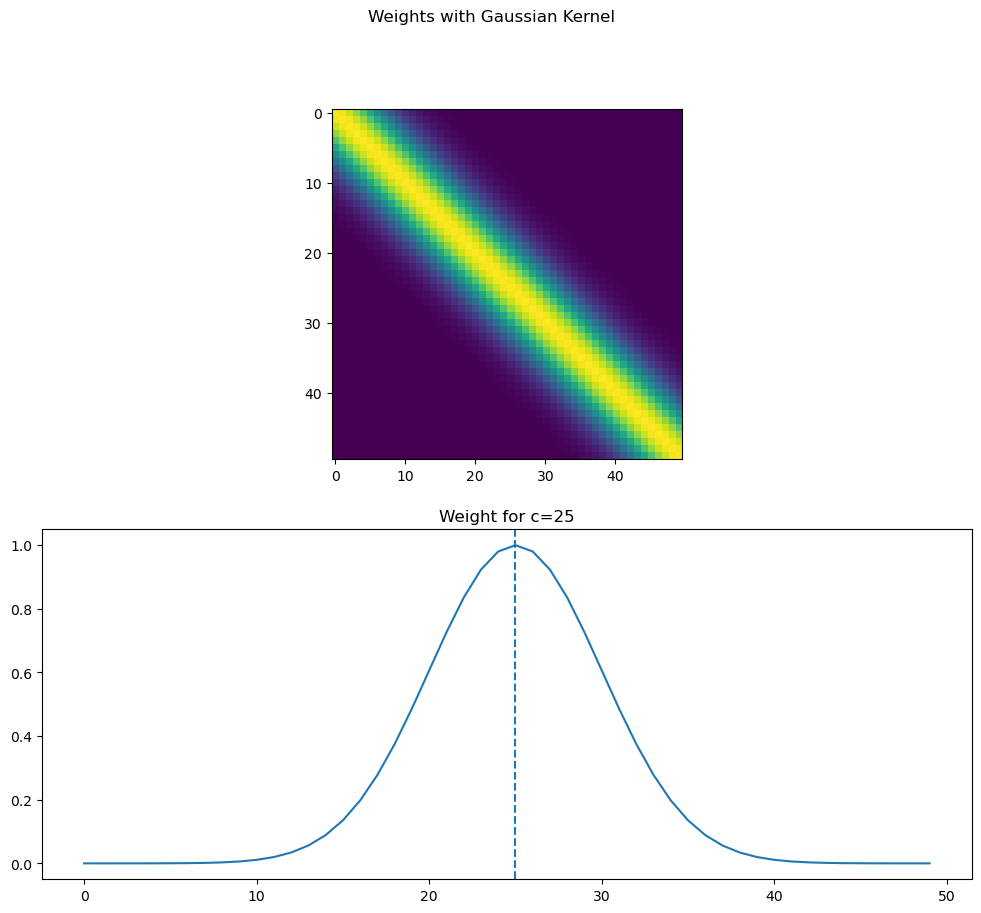

In [4]:
network = ndyn.Network(N=50, T=20)
ndyn.plot_weight(network, 25, 'Weights with Gaussian Kernel')

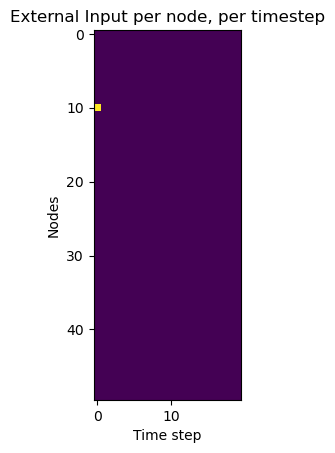

In [5]:
external_input = np.zeros((network.N, network.T))
external_input[10, 0] = 1

ndyn.plot_external_input(external_input)

In [6]:
solution = network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
print(solution)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0  1 ... 18 19]
        y: [[ 0.000e+00  1.389e-02 ...  3.511e-06  2.995e-06]
            [ 0.000e+00  2.002e-02 ...  4.359e-06  3.718e-06]
            ...
            [ 0.000e+00  3.391e-11 ...  3.818e-12  3.257e-12]
            [ 0.000e+00  1.241e-11 ...  1.734e-12  1.479e-12]]
      sol: None
 t_events: None
 y_events: None
     nfev: 158
     njev: 0
      nlu: 0


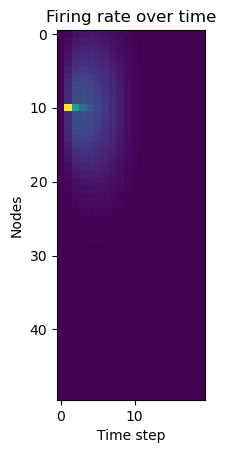

In [7]:
ndyn.plot_firing_rate(network, "Firing rate over time")

# Simulation #2 - "Flashing" external input with strong recurrent weight

We're looking to see that

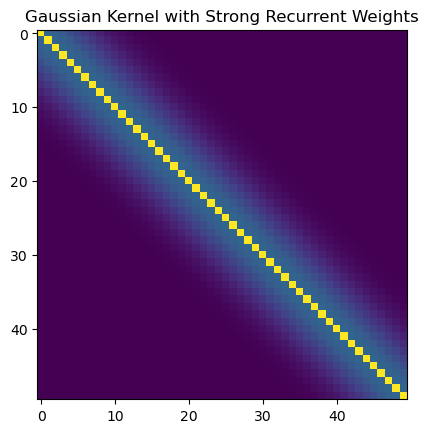

In [8]:
np.fill_diagonal(network.W, 3)
ndyn.plot_weight_matrix(network, 'Gaussian Kernel with Strong Recurrent Weights')

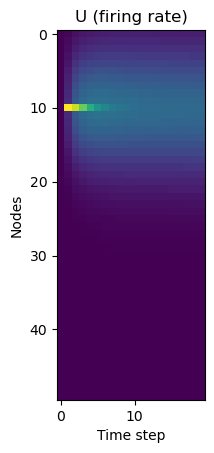

In [9]:
network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
ndyn.plot_firing_rate(network)

# Simulation 3 - Constant Stimulus with Gaussian Function

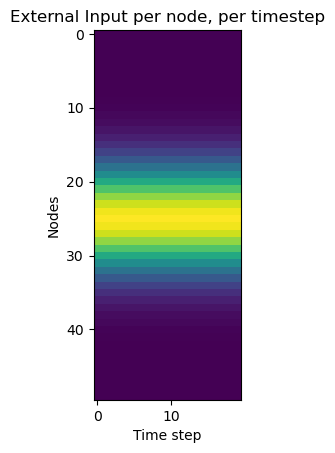

In [10]:
network = ndyn.Network(50, 20)
external_input = ndyn.get_diff_matrix(network.N, 25)
external_input = ndyn.gaussian_func(external_input)
external_input = np.tile(external_input, (1, network.T))
ndyn.plot_external_input(external_input)

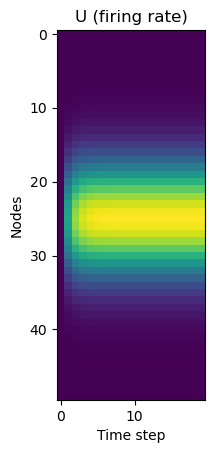

In [11]:
network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
ndyn.plot_firing_rate(network)

# Simulation - Periodic Stimulus
"To mimic real situations more precisely, such as when the stimulus is the orientation or moving direction of objects, we restrict the stimulus in the simulation to be a periodical variable. More exactly, we consider stimulus x (and so does the preferred stimulus of neurons) in the range (−π, π ], with x = θ and x = 2π + θ being the same. Under this condition, the steady states of the network will no longer have the exact gaussian form as in equation 2.4. However, provided that the value of a is not too large, say, a < π as considered here, the bell shape of steady states still holds, as confirmed by the simulation. With the periodic condition, the form of recurrent interactions is adjusted..." (Wu & Amari 2005)

[[0. 1. 2. ... 3. 2. 1.]
 [1. 0. 1. ... 4. 3. 2.]
 [2. 1. 0. ... 5. 4. 3.]
 ...
 [3. 4. 5. ... 0. 1. 2.]
 [2. 3. 4. ... 1. 0. 1.]
 [1. 2. 3. ... 2. 1. 0.]]


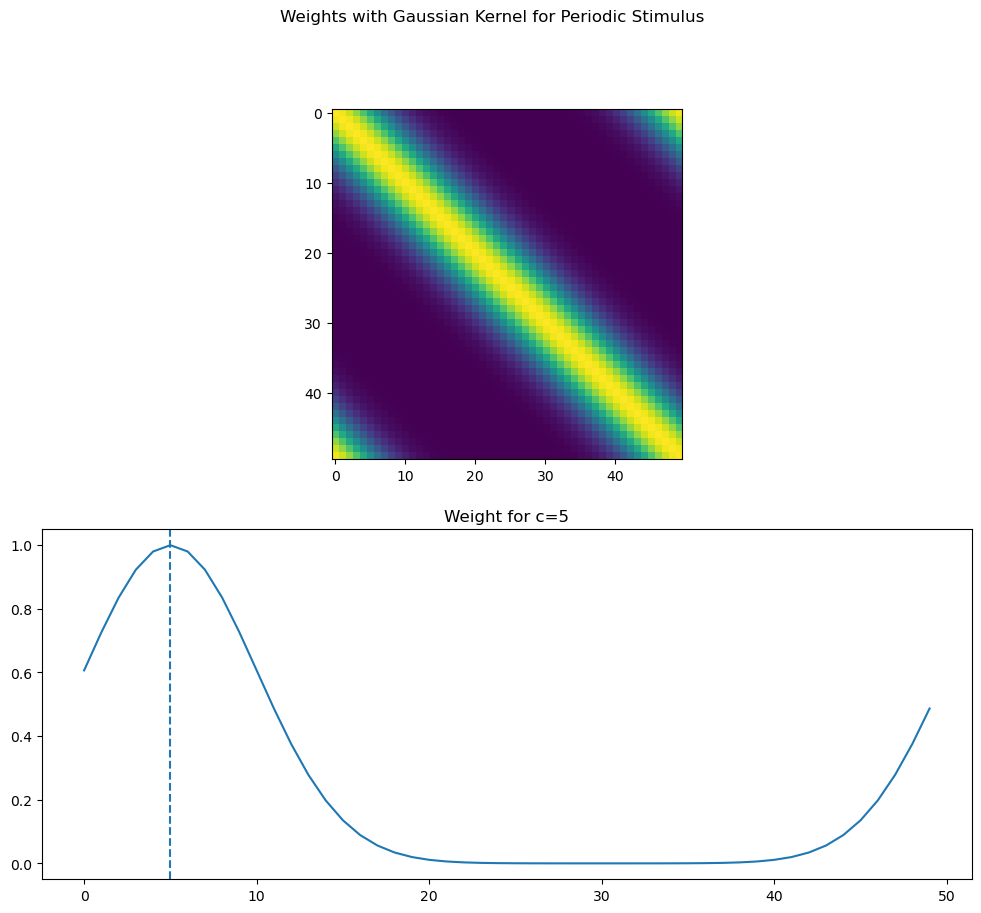

In [12]:
# Weight matrix for periodic stimulus
def weights_for_periodic_stimulus(N, a:int = 0.2):
    row_indices = np.arange(N, step=1.0).reshape(-1, 1)
    col_indices = np.arange(N, step=1.0).reshape(1, -1)
    diff_matrix = np.minimum(np.fabs(col_indices - row_indices), np.subtract(float(N), np.fabs(col_indices - row_indices)))
    print(diff_matrix)

    # gt_pi = diff_matrix > np.pi
    # lte_pi = diff_matrix <= np.pi
    # diff_matrix[gt_pi] = np.exp(-np.power(diff_matrix[gt_pi], 2) / (2 * np.power(a, 2)))
    # diff_matrix[lte_pi] = np.exp(-np.power(2 * np.pi * diff_matrix[lte_pi], 2) / (2 * np.power(a, 2)))
    w = ndyn.gaussian_func(diff_matrix, a)
    return w

network = ndyn.Network(N=50, T=20, W_func=weights_for_periodic_stimulus, W_kwargs={'a': 0.2})
ndyn.plot_weight(network, 5, 'Weights with Gaussian Kernel for Periodic Stimulus')

[[49.]
 [48.]
 [47.]
 [46.]
 [45.]
 [44.]
 [43.]
 [42.]
 [41.]
 [40.]
 [39.]
 [38.]
 [37.]
 [36.]
 [35.]
 [34.]
 [33.]
 [32.]
 [31.]
 [30.]
 [29.]
 [28.]
 [27.]
 [26.]
 [25.]
 [24.]
 [23.]
 [22.]
 [21.]
 [20.]
 [19.]
 [18.]
 [17.]
 [16.]
 [15.]
 [14.]
 [13.]
 [12.]
 [11.]
 [10.]
 [ 9.]
 [ 8.]
 [ 7.]
 [ 6.]
 [ 5.]
 [ 4.]
 [ 3.]
 [ 2.]
 [ 1.]
 [ 0.]]
[[ 1.  4.  7. 10. 13. 16. 19. 22. 25. 22. 19. 16. 13. 10.  7.  4.  1.  2.
   5.  8.]
 [ 2.  5.  8. 11. 14. 17. 20. 23. 24. 21. 18. 15. 12.  9.  6.  3.  0.  3.
   6.  9.]
 [ 3.  6.  9. 12. 15. 18. 21. 24. 23. 20. 17. 14. 11.  8.  5.  2.  1.  4.
   7. 10.]
 [ 4.  7. 10. 13. 16. 19. 22. 25. 22. 19. 16. 13. 10.  7.  4.  1.  2.  5.
   8. 11.]
 [ 5.  8. 11. 14. 17. 20. 23. 24. 21. 18. 15. 12.  9.  6.  3.  0.  3.  6.
   9. 12.]
 [ 6.  9. 12. 15. 18. 21. 24. 23. 20. 17. 14. 11.  8.  5.  2.  1.  4.  7.
  10. 13.]
 [ 7. 10. 13. 16. 19. 22. 25. 22. 19. 16. 13. 10.  7.  4.  1.  2.  5.  8.
  11. 14.]
 [ 8. 11. 14. 17. 20. 23. 24. 21. 18. 15. 12.  9.  6. 

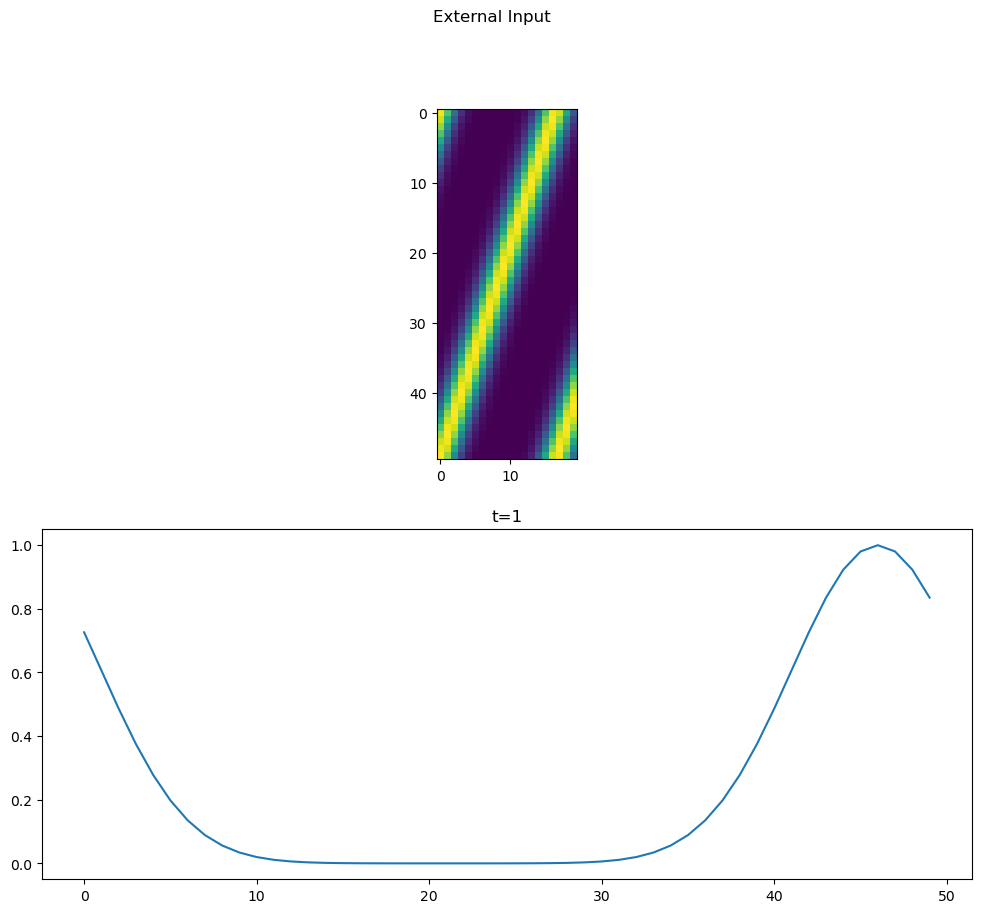

In [26]:
# External input with moving perturbation

velocity = 3
gamma = 1
t = np.tile(np.arange(0, network.T), (network.N, 1))
h = velocity * t
# print(h)
# diff_matrix = ndyn.get_diff_matrix(network.N, 24)
row_indices = np.arange(network.N, step=1.0).reshape(-1, 1)
row_indices = np.fabs(row_indices - 49) # TODO, c=25 at t=0 is undefined behavior, but it shouldn't be. The gaussian function will diverge
print(row_indices)
# diff_matrix = row_indices - h
diff_matrix = np.minimum(np.fabs(row_indices - h), np.subtract(float(network.N), np.fabs(row_indices - h)))
# neg_diff_matrix = diff_matrix < 0
# diff_matrix[neg_diff_matrix] = network.N + diff_matrix[neg_diff_matrix]
# diff_matrix = np.maximum(row_indices - h, np.subtract(float(network.N), np.fabs(row_indices - h)))
print(diff_matrix)
external_input = ndyn.gaussian_func(diff_matrix)

# diff_matrix = np.tile(diff_matrix, (1, network.T))
# diff_matrix = diff_matrix - h
# external_input = gamma * ndyn.gaussian_func(diff_matrix)
ndyn.plot_external_input_at_t(external_input, 1)

In [14]:
# External input with moving perturbation (coupled with neuron)
# perturbation_start_index = 15
# velocity = 1
# gamma = 1
# h = velocity * np.arange(1, min(network.T + 1, network.N - perturbation_start_index + 1))
# h = np.diag(h)
# # print(h)
#
# external_input = ndyn.get_diff_matrix(network.N, 25)
# start_n = perturbation_start_index
# end_n = start_n + len(h)
# start_t = 0
# end_t = h.shape[1]
#
# external_input = np.tile(external_input, (1, network.T))
# external_input[start_n:end_n, start_t:end_t] = external_input[start_n:end_n, start_t:end_t] - h
# print(external_input.shape)
# external_input = gamma * ndyn.gaussian_func(external_input)
#
# ndyn.plot_external_input_at_t(external_input, 17)

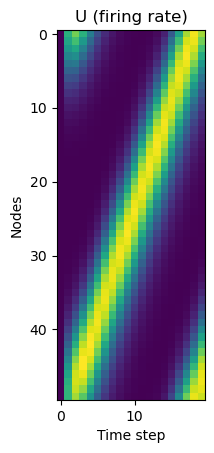

In [27]:
network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
ndyn.plot_firing_rate(network)

In [16]:
tau = 5
mu = 5
U = np.zeros((num_nodes, num_time_steps))
Oc = U[:, 0]

solution = sp.integrate.solve_ivp(nn_ode, [0, num_time_steps - 1], U[:, 0], t_eval=np.arange(0, num_time_steps), args=(w, external_input, tau, mu))
print(solution)
plt.title("Firing rate over time")
plt.xlabel("Time step")
plt.plot(solution.t, solution.y.T);

NameError: name 'num_nodes' is not defined

In [ ]:
# TODOs
# use contour plot -- DONE
# critical value of recurrent weight . if large enough, the network can hold non zero response after external input goes away -- DONE
# generate moving input -- DONE (NEEDS REVIEW)
# h = v * t (v is speed) -- DONE (NEEDS REVIEW)
# add noise from 2020 bioxiv paper
